In [1]:
import os, sys
%pylab inline
import pandas as pd
from importlib import reload
import inputs, classifiers, run
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors

Populating the interactive namespace from numpy and matplotlib


In [3]:
export_figs = True
style = "default" if export_figs else "fast"
if style == "fast":
    plt.style.use("fast")
    plt.rcParams["figure.figsize"]=(8,3)
    [plt.rcParams.__setitem__(fld, 'white') for fld,val in plt.rcParams.items() if (val == 'black') and ('boxplot' not in fld)]
    [plt.rcParams.__setitem__(fld,  12)     for fld in plt.rcParams if any([sz in fld for sz in ["labelsize", ".size"]])]
else:
    plt.style.use("default")
    plt.rcParams["figure.figsize"]=(8,5)    

In [205]:
set_alpha = lambda col, al: tuple(list(col[:3]) + [al])

In [4]:
import inputs, classifiers, run
reload(classifiers)
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm

In [5]:
import logging
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger("make_figures")

In [6]:
def get_ylim(y,scale=1.1):
    min_y = np.min(y)
    max_y = np.max(y)
    dy    = max_y - min_y
    return [min_y - dy*scale/2, max_y + dy*scale/2]

In [7]:
def load_results(pairs, whiskers, window_size, clf, name = "full_100x", max_load = 10000):
    name = f"{name}_{pairs}_{int(window_size*1000)}ms_W{whiskers}"
    logger.info(f"{name=}")
    config = {"output_prefix":"", "raw":False, "mock":"null", "classifier":clf}
    output_dir = run.get_output_folder_name(config, head = f"data/sweeps/{name}")
    logger.info(output_dir)
    records = []
    for f in os.scandir(output_dir):
        if f.is_file() and f.name.endswith(".csv"):
            records.append(pd.read_csv(f))
        if len(records) >= max_load:
            break
    logger.info(f"Read {len(records)} csv files, with {max_load=}")
    df = pd.concat(records)
    logger.info(f"Created dataframe with {len(df)} rows.")
    col_names = list(df.columns)
    logger.info(f"Columns: {col_names}")
    df.head()
    logger.info(f"Accuracy at 3 sec. using all ROIs at 2 Hz: {mean(df[(df.start_time == 3) & (df.shuf == 0) & (df.n_sub==145) & (df.freq==2)]['test_score']):1.3f}")
    # Set a flag for whether this was a shuffle run or not.
    df.loc[df.shuf>0, "shuf"]=1
    df2 = df.groupby(['n_sub','shuf','freq','start_time'], as_index=False).agg({'train_score':['mean', 'std'], 'test_score':['mean', 'std']})
    df2.columns = [c  + ("_" if len(d) else "") + d for (c,d) in df2.columns.to_flat_index()]
    return df2

In [9]:
def get_best_coefs(config, clf, full = False, compute_accuracy = False, search = None, response_threshold = 0, min_resp_trials = 0):
    X, y, t, X_sub, ind_glom, ind_t = inputs.generate_input_for_config(config, return_full = True,
                                                                       response_threshold = response_threshold,
                                                                       min_resp_trials = min_resp_trials)
    if search is None:
        search = run.get_pipeline(classifier=clf, return_pipe=False)
    if compute_accuracy:
        train_acc, test_acc = run.run_single(config, search, classifiers.score_function[clf],
                                                                       response_threshold = response_threshold,
                                                                       min_resp_trials = min_resp_trials)
        print(f"{train_acc=:1.3f}, {test_acc=:1.3f}")
    if len(X):
        search.fit(X,y)
        best_coefs = search.best_estimator_["clf"].coef_
    else:
        print("X was empty.")
        best_coefs = []
    return best_coefs if not full else (best_coefs, (X, y, t, X_sub, ind_glom, ind_t))

In [10]:
freq_cols = {
    (0,2): "blue", (1,2):"blue",
    (0,20):"red", (1,20):"red",
}
corr_cols = {"corr":"red",
             "acorr":"plum"}

def plot_results(df2, start_time=3, do_plot = True):
    df_sub  = {(sh,freq):df2[(df2.start_time == start_time) & (df2.freq==freq) & (df2.shuf==sh)].sort_values(by=["n_sub"]) for sh in [0,1] for freq in [2,20]}
    h,xx,yy,ss = [],{},{},{}
    for (sh,freq),col in sorted(freq_cols.items()):
        x = df_sub[sh,freq]["n_sub"].values
        ym= df_sub[sh,freq]["test_score_mean"]
        ys= df_sub[sh,freq]["test_score_std"]
        if do_plot:
            fill_between(x, ym-ys, ym+ys, color=list(mcolors.to_rgb(col)) + [0.2])    
            h.append(plot(x,ym,"--" if sh else "-", color=col, label=f"{freq}Hz " + ("sh" if sh else "")))
        else:
            xx[sh,freq] = copy(x)
            yy[sh,freq] = copy(ym)
            ss[sh,freq] = copy(ys)
    if do_plot:
        xlim(x[0],x[-1]); ylim(0.3,1)
    return h if do_plot else (xx,yy,ss)

# The Decoding Coefficients

In [9]:
inputs.logger.setLevel(logging.WARNING)
whiskers = "both"
window_size = 2
start_time  = 3
clf = "lasso_lars_no_intercept"
decoding_coefs  = {(pair,freq):get_best_coefs(inputs.Config(seed=0,shuf=0, window_size = window_size, n_sub = 145, freq=freq, pairs=pair, whiskers=whiskers, start_time = start_time), clf, full = False) for pair in ["AB","CD","EF"] for freq in [2,20]}
decoding_inputs = {(pair,freq):get_best_coefs(inputs.Config(seed=0,shuf=0, window_size = window_size, n_sub = 145, freq=freq, pairs=pair, whiskers=whiskers, start_time = start_time), clf, full = True)[1] for pair in ["AB","CD","EF"] for freq in [2,20]}

In [10]:
saved_data = np.load("data/data.p", allow_pickle=True).item()
ind2expr = saved_data["ind2expr"]
records = []
for i, expr in enumerate(ind2expr):
    new_record = {"experiment":expr[0], "roi":expr[1]}
    new_record.update({f"{pair}_{freq}Hz":(coefs[0][i] if "svc_linear" in clf else coefs[i]) for (pair,freq),coefs in decoding_coefs.items()})
    records.append(new_record)
df_decoding_coefs = pd.DataFrame().from_records(records)
df_decoding_coefs.to_csv("decoding_coefs.csv", index = False)

# Inspecting Decoding

In [17]:
def plot_timecourses(X,y,t, style="-"):
    m = [mean(X[y>0,:],axis=0), mean(X[y<0,:],axis=0)]
    s = [std(X[y>0,:],axis=0),   std(X[y<0,:],axis=0)]
    for i, (col, lab) in enumerate([([1,0,0], "corr"),([0,0,1], "anti-corr")]):
        fill_between(t, m[i]-s[i], m[i]+s[i], color=col + [0.2])
        plot(t, m[i], style, color=col, label=lab);

def vline(t, *args, **kwargs):
    yl = ylim()
    plot([t,t], yl, *args, **kwargs)
    ylim(yl)

train_acc=0.938
 test_acc=0.600


time_indices: [31]


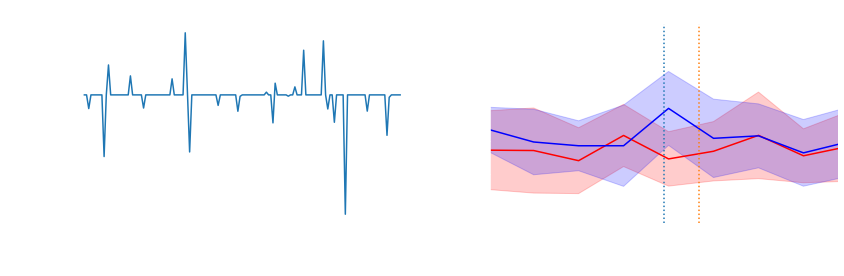

In [12]:
wsz = 0.025;
freq = 20
start_time = -2 + 3
seed   = 1
clf    = "svc_linear_l1" #l1_no_intercept"
raw = True
config = inputs.Config(seed=seed, shuf=0, window_size = wsz, n_sub = 145, freq=freq, pairs="CD", whiskers="yes", start_time = start_time)
search = run.get_pipeline(classifier=clf, raw=raw, return_pipe=False)
train_acc, test_acc = run.run_single(config, search, classifiers.score_function[clf])
print(f"{train_acc=:1.3f}")
print(f"{ test_acc=:1.3f}")
coefs, (X,y,t,X_sub,ind_glom) = get_best_coefs(config, clf, full=True, search = search)
ind_wnd = where((t>=start_time) & (t<=start_time + wsz))[0]
print(f"time_indices: {ind_wnd}")
iplot = argmax(abs(coefs[0]))
u = np.einsum('ijk,j',X_sub, coefs[0])
figure(figsize=(12,4))
subplot(1,2,1); plot(coefs[0]); xlabel("ROI"); ylabel("Weight")
toffset = 3
subplot(1,2,2); plot_timecourses(0*u + X_sub[:,iplot,:], y, t - toffset); title(f"{iplot=}");
#xlim([-3,3])
xlim(start_time-toffset - min(wsz*5,1), start_time-toffset+min(wsz*5,1));
vline(start_time-toffset, ":"); vline(start_time + wsz - toffset, ":"); xlabel("Time (sec.)"); ylabel("dF/F")
tight_layout()

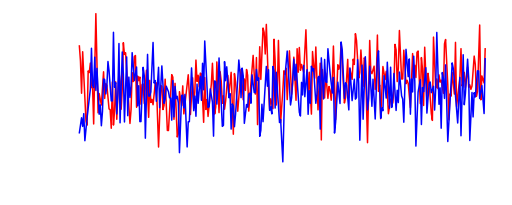

In [13]:
plot(mean(X_sub[y>0,iplot,:],axis=0),"r")
plot(mean(X_sub[y<0,iplot,:],axis=0),"b")

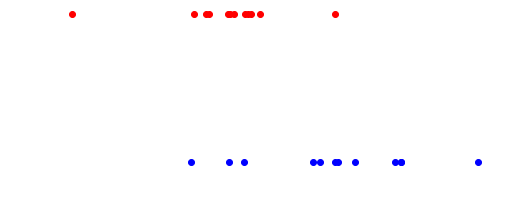

In [14]:
plot(X_sub[y>0, iplot, 31], [1]*(sum(y>0)),"ro")
plot(X_sub[y<0, iplot, 31],[-1]*(sum(y<0)),"bo")

# Decoding at 20 Hz

In [15]:
whiskers = "both"
window_size = 2
start_time = 3
clf  = "lasso_lars_no_intercept"
dfAB = load_results("AB", whiskers, window_size, clf)
dfCD = load_results("CD", whiskers, window_size, clf)
dfEF = load_results("EF", whiskers, window_size, clf)

In [16]:
inputs.logger.setLevel(logging.DEBUG)
configAB = inputs.Config(seed=0,shuf=0, window_size = window_size, n_sub = 145, freq=freq, pairs="AB", whiskers=whiskers, start_time = start_time)
best_coefs, (X,y,t,X_sub,ind_glom) = get_best_coefs(configAB, clf, full = True)

DEBUG:inputs:Generating input for Config(seed=0, n_sub=145, shuf=0, freq=20, pairs='AB', whiskers='both', window_size=2, start_time=3)


DEBUG:inputs:Using pairs=['AB'].


DEBUG:inputs:Picked config.n_sub=145/n_glom=145 glomeruli: ind_glom=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]


DEBUG:inputs:Picked time indices 93 (3.010 sec.) to 154 (4.984 sec.) to span [config.start_time=3, end_time=5).


DEBUG:inputs:Shape of predictors: X.shape=(48, 145)


DEBUG:inputs:(stim='20Hzanti-corr01', pair='AB') -> [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='20Hzanti-corr02', pair='AB') -> [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='20Hzcorr01', pair='AB') -> [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


DEBUG:inputs:(stim='20Hzcorr02', pair='AB') -> [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


DEBUG:inputs:Labels: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


DEBUG:inputs:Generating input for Config(seed=0, n_sub=145, shuf=0, freq=20, pairs='AB', whiskers='both', window_size=2, start_time=3)


DEBUG:inputs:Using pairs=['AB'].


DEBUG:inputs:Picked config.n_sub=145/n_glom=145 glomeruli: ind_glom=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]


DEBUG:inputs:Picked time indices 93 (3.010 sec.) to 154 (4.984 sec.) to span [config.start_time=3, end_time=5).


DEBUG:inputs:Shape of predictors: X.shape=(48, 145)


DEBUG:inputs:(stim='20Hzanti-corr01', pair='AB') -> [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='20Hzanti-corr02', pair='AB') -> [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='20Hzcorr01', pair='AB') -> [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


DEBUG:inputs:(stim='20Hzcorr02', pair='AB') -> [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


DEBUG:inputs:Labels: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


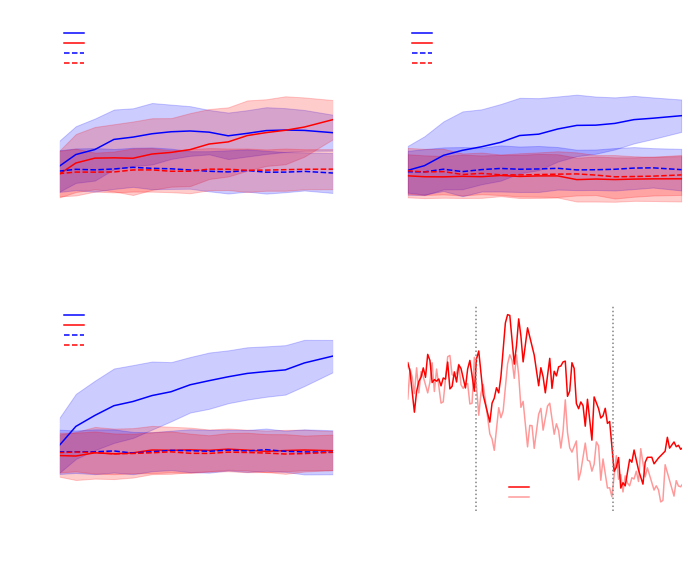

In [17]:
figure(figsize=(10,8))
subplot(2,2,3); hEF = plot_results(dfEF, start_time); xlabel("# ROIs"); ylabel("Accuracy"); title("Decoding corr. vs. anti-corr. (EF)")
legend(frameon=False, labelspacing=0,loc="upper left", fontsize=10, borderpad=0)
subplot(2,2,1); hAB = plot_results(dfAB, start_time); xlabel("# ROIs"); ylabel("Accuracy"); title("Decoding corr. vs. anti-corr. (AB)")
legend(frameon=False, labelspacing=0,loc="upper left", fontsize=10, borderpad=0)
subplot(2,2,2); hCD = plot_results(dfCD, start_time); xlabel("# ROIs"); ylabel("Accuracy"); title("Decoding corr. vs. anti-corr. (CD)")
legend(frameon=False, labelspacing=0,loc="upper left", fontsize=10, borderpad=0)
subplot(2,2,4)
plot(t-3, mean(X_sub[y>0],axis=0)[argmax(best_coefs)], color=corr_cols["corr"], label="corr")
plot(t-3, mean(X_sub[y<0],axis=0)[argmax(best_coefs)], color=list(mcolors.to_rgb(corr_cols["corr"]))+[0.4], label="anti-corr")
legend(frameon=False, fontsize=10, loc="lower center", labelspacing=0)
yl = ylim(); plot([0,0],yl, ":",color="gray"); plot([2,2],yl, ":",color="gray"); ylim(yl)
title(f"Highest weight ROI for AB, 20 Hz (#{argmax(best_coefs)})")
xlabel("Time (sec.)"); ylabel("dF/F");
xlim(-1,3)
tight_layout()
if export_figs:
    file_name = "basic_decoding.pdf"
    print(file_name)
    savefig(file_name, bbox_inches = "tight")

# Effect of Whiskers

In [18]:
logger.setLevel(logging.WARNING)
window_size = 2
start_time = 3
clf  = "lasso_lars_no_intercept"
df_whis = {(pair, whis):load_results(pair, whis, window_size, clf) for pair in ["AB", "CD", "EF"] for whis in ["yes","no"]}
xys = {k:plot_results(df, start_time = 3, do_plot = False) for k, df in df_whis.items()}

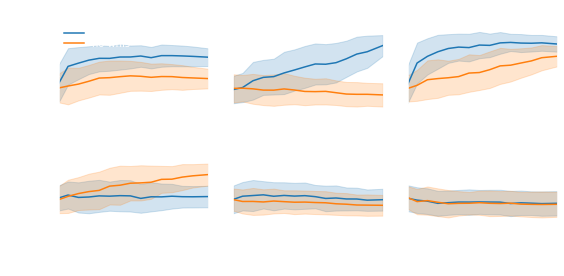

In [19]:
whis_cols = {"yes":"C0", "no":"C1"}
show_shuf = False
sh_freq = [(0,2),(0,20)] + ([(1,2),(1,20)] if show_shuf else [])
min_xlabs = True
min_ylabs = True
figure(figsize=(8,4 + (show_shuf)*4))
gs = GridSpec(4 if show_shuf else 2, 3)
ax = {}
for ip, pair in enumerate(["AB", "CD","EF"]):
    for whis in ["yes","no"]:
        xx,yy,ss = xys[(pair, whis)]
        for isf, (sh, freq) in enumerate(sh_freq):
            ax[isf,ip] = subplot(gs[isf,ip]) if (isf,ip) not in ax else ax[isf,ip]
            ax[isf,ip].fill_between(xx[(sh,freq)], yy[(sh,freq)] - ss[(sh,freq)],  yy[(sh,freq)] + ss[(sh,freq)], color=list(mcolors.to_rgb(whis_cols[whis]))+[0.2])            
            ax[isf,ip].plot(xx[(sh,freq)], yy[(sh,freq)], color=whis_cols[whis], label="whis" if whis == "yes" else "no whis")
            
for ip, pair in enumerate(["AB", "CD", "EF"]):
    for isf, (sh, freq) in enumerate(sh_freq):
        ax[isf,ip].set_ylim(0.3,1)
        ax[isf,ip].set_xticks(arange(0,150,25))
        ax[isf,ip].set_yticks(arange(0.3,1.01,0.1))
        (isf != 3) and (isf != len(sh_freq)-1) and min_xlabs and ax[isf,ip].set_xticklabels([])
        (ip  != 0) and min_ylabs and ax[isf,ip].set_yticklabels([])    
        (ip  == 0) and ax[isf,ip].set_ylabel(f"{freq}Hz" + (" (sh) " if sh else ""))
        (isf == 0) and ax[isf,ip].set_title(pair)
        (isf == len(sh_freq)-1) and ax[isf,ip].set_xlabel("# ROIs")
        ax[isf,ip].set_xlim(xx[0,20][0],xx[0,20][-1])
ax[0,0].legend(loc="upper left", frameon=False, fontsize=10, labelspacing=0, borderpad=0)
tight_layout(h_pad=0)
if export_figs:
    file_name = "effect_of_whiskers.pdf"
    savefig(file_name, bbox_inches="tight")
    print("Wrote {file_name}.")

In [20]:
inputs.logger.setLevel(logging.INFO)
freq = 2; window_size = 2; start_time = 3;
pair_freqs = [("AB", 20), ("CD", 2), ("EF", 2)]
configs = {(pair, freq, whis):inputs.Config(seed=0,shuf=0, window_size = window_size, n_sub = 145, freq=freq, pairs=pair, whiskers=whis, start_time = start_time) for whis in ["yes","no"] for (pair, freq) in pair_freqs}
best_coefs = {k:get_best_coefs(config, clf) for k,config in configs.items()}
XY = {k:inputs.generate_input_for_config(config, return_full = True) for k,config in configs.items()}

In [21]:
def plot_coefs(coefs, offset, color, label):
    x = arange(len(coefs)) + offset
    return plot([x,x],[0*coefs, coefs],color=color, label=label)

0.4336727310691665


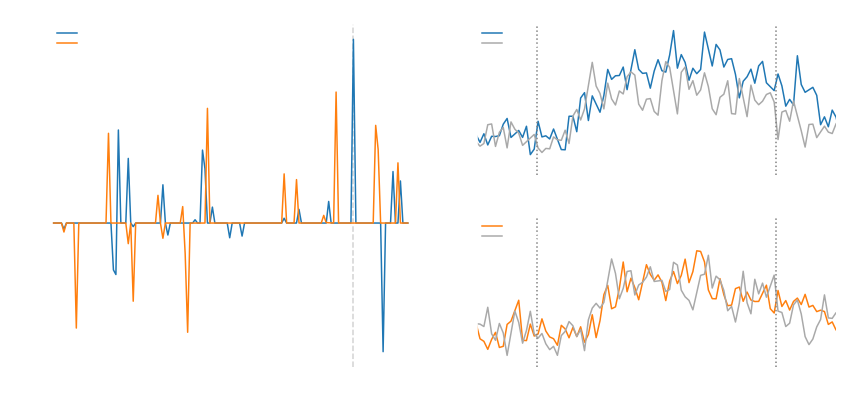

In [22]:
# Find the best coefs of CD at 2 Hz with whiskers
gs = GridSpec(2,2)
key = ("EF", 2, "yes")
#key = ("AB", 20, "yes")
key_no = (key[0], key[1], "no")
coefs = best_coefs[key]
coefs_no = best_coefs[key_no]
order = argsort(coefs)
which_coef = order[-1]
figure(figsize=(12,6)); subplot(gs[:,0]); plot(coefs, label="whiskers"); plot(coefs_no, label="no whiskers")
yl = ylim(); plot([which_coef]*2, yl, "--", color="lightgray", zorder=-5); ylim(yl);
legend(frameon=False, labelspacing=0, borderpad=0, fontsize=10)
xlim(0,len(coefs))
title(f"Coefficients when decoding pair {key[0]} at {key[1]} Hz")
xlabel("ROI #")
print(coefs[which_coef])
yl = []
for iw, whis in enumerate(["yes", "no"]):
    subplot(gs[iw,1])
    X,y,t,X_sub,ind_glom = XY["CD",2,whis]
    plot(t-3, mean(X_sub[y>0],axis=0)[which_coef], "C0" if whis=="yes" else "C1", label = "corr")
    plot(t-3, mean(X_sub[y<0],axis=0)[which_coef], "darkgray", label = "anti-corr")
    yl = ylim() if not yl else yl
    [plot([t,t],yl, ":", color="gray") for t in [0,2]]
    ylim(yl)
    (iw == 0) and title(f"Mean response of ROI #{which_coef}")
    legend(frameon=False, labelspacing=0, borderpad=0, fontsize=10, loc = "upper left")
    (iw == 1) and xlabel("Time (sec.)")
    ylabel(f"{'whiskers' if whis=='yes' else 'no whiskers'}")
    xlim(-0.5,2.5)
tight_layout()
if export_figs:
    file_name = f"whis_coefs_{key[0]}_{key[1]}Hz_ROI{which_coef}.pdf"
    print(file_name)
    savefig(file_name, bbox_inches="tight")

# Effect of Window Size

In [11]:
xys = {}

In [12]:
logger.setLevel(logging.WARNING)
name = "more_1500x"
whis = "yes"
clf  = "lasso_lars_no_intercept"
window_sizes = [0.025, 0.05, 0.1, 2]
df_wsz = {(pair, wsz):load_results(pair, whis, wsz, clf, name = name, max_load = 100) for pair in ["AB", "CD", "EF"] for wsz in window_sizes}

In [13]:
n_glom = 145
for (pair, wsz), df in df_wsz.items():
    for (sh, freq) in [(0,2),(0,20),(1,2),(1,20)]:
        xys[name,pair,wsz,sh,freq] = df[(df.n_sub==n_glom) & (df.shuf==sh) & (df.freq==freq)][["start_time", "test_score_mean", "test_score_std"]].sort_values(by="start_time").to_numpy().T

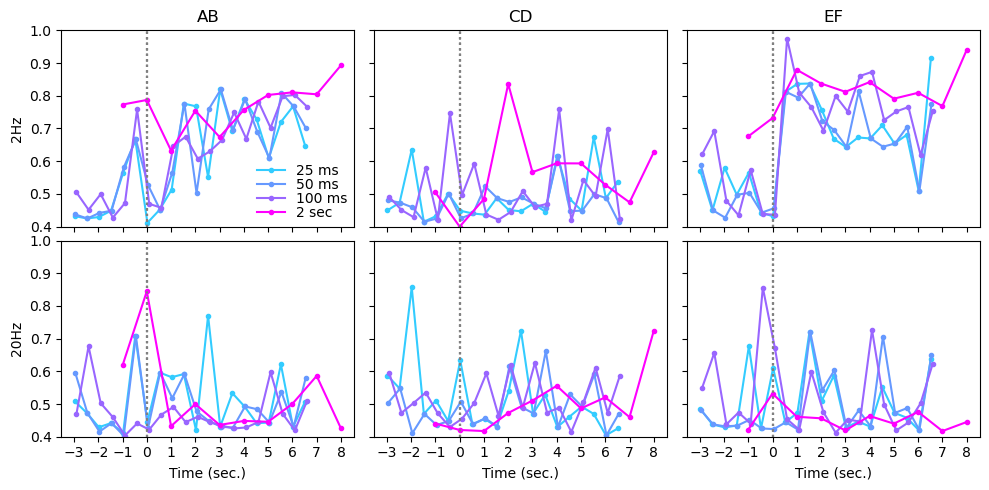

In [14]:
cm_wsz   = cm.cool
wsz_cols = {0.025:cm_wsz(0.2), 0.05:cm_wsz(0.4), 0.1:cm_wsz(0.6), 2:cm_wsz(1.)}
wsz_labs = {0.025:"25 ms", 0.05:"50 ms", 0.1:"100 ms", 2:"2 sec"}
show_shuf = False
sh_freq = [(0,2),(0,20)] + ([(1,2),(1,20)] if show_shuf else [])
min_xlabs = True
min_ylabs = True
figure(figsize=(10, 5 + (show_shuf)*5))
gs = GridSpec(4 if show_shuf else 2, 3)
ax = {}
for ip, pair in enumerate(["AB", "CD","EF"]):
    for wsz in window_sizes:
        for isf, (sh, freq) in enumerate(sh_freq):
            xx,yy,ss = xys[name,pair, wsz,sh,freq]            
            ax[isf,ip] = subplot(gs[isf,ip]) if (isf,ip) not in ax else ax[isf,ip]
            (wsz > 2) and ax[isf,ip].fill_between(xx - 3 + wsz, yy - ss,  yy + ss, color=list(mcolors.to_rgb(wsz_cols[wsz]))+[0.2])            
            ax[isf,ip].plot(xx - 3 + wsz, yy, "o-", markersize=3, color=wsz_cols[wsz], label=wsz_labs[wsz], linewidth=1.5)
            ax[isf,ip].plot([0,0],[0.4,1],":",color="gray");
            ax[isf,ip].set_ylim([0.4,1])
            
for ip, pair in enumerate(["AB", "CD", "EF"]):
    for isf, (sh, freq) in enumerate(sh_freq):
        ax[isf,ip].set_ylim(0.4,1)
        ax[isf,ip].set_xticks(arange(0,12,1)-3)
        ax[isf,ip].set_yticks(arange(0.4,1.01,0.1))
        (isf != 3) and (isf != len(sh_freq)-1) and min_xlabs and ax[isf,ip].set_xticklabels([])
        (ip  != 0) and min_ylabs and ax[isf,ip].set_yticklabels([])    
        (ip  == 0) and ax[isf,ip].set_ylabel(f"{freq}Hz" + (" (sh) " if sh else ""))
        (isf == 0) and ax[isf,ip].set_title(pair)
        (isf == len(sh_freq)-1) and ax[isf,ip].set_xlabel("Time (sec.)")
        #ax[isf,ip].set_xlim(xx[0,20][0],xx[0,20][-1])
ax[0,0].legend(frameon=False, fontsize=10, labelspacing=0, borderpad=0)
tight_layout(h_pad=0)
savefig(f"effect_of_window_size_{name}.pdf", bbox_inches="tight")

# Inspecting Decoding Performance

In [395]:
wsz  = 2
freq = 20
pair = "CD"
whis = "yes"
odour_onset = 3
#which_start_time = 9.6
#start_time = which_start_time + odour_onset
start_time = 9
response_threshold = 3.
min_resp_trials = 0.75
conf = inputs.Config(seed=0,shuf=0, window_size = wsz, n_sub = 145, freq = freq, pairs = pair, whiskers = whis, start_time = start_time)
best_coefs, (X,y,t,X_sub,ind_glom,ind_t) = get_best_coefs(conf, "lasso_lars_no_intercept",
                                                          compute_accuracy = True,
                                                          full = True,
                                                          response_threshold = response_threshold,
                                                          min_resp_trials = min_resp_trials)
X_sub_max   = np.max(X_sub, axis=0)
coefs_order = argsort(best_coefs)
#xx,yy,ss,nn = xysnf[pair, wsz, 0, freq, response_threshold, min_resp_trials]
#xx,yy,ss = xys[name, pair, wsz, False,freq]            

DEBUG:inputs:generate_input_for_config


DEBUG:inputs:Generating input for Config(seed=0, n_sub=145, shuf=0, freq=20, pairs='CD', whiskers='yes', window_size=2, start_time=9)


DEBUG:inputs:Using pairs=['CD'].


DEBUG:inputs:Using 62 bins to approximate a desired window size of 2.000 with dt=0.032.


DEBUG:inputs:Picked time indices 279 (9.030 sec.) to 340 (11.004 sec.) to approximately span a config.window_size=2.000 second window starting at config.start_time=9.000 seconds.


DEBUG:inputs:Filtering glomeruli by responsivity using response_threshold=3.0 and min_resp_trials=0.75.


DEBUG:inputs:filter_by_responsivity


DEBUG:inputs:Z-score range: -31.732 - 28.567.


DEBUG:inputs:Found 128 glomeruli with at least one responsive trial.


DEBUG:inputs:Received min_resp_trials=0.75


DEBUG:inputs:Interpreted as min_resp_trials=18 trials.


DEBUG:inputs:Flagging the 1 glomeruli with at least 18 responsive trials.


DEBUG:inputs:Found 1 responsive glomeruli: [141]


DEBUG:inputs:Picked 1/n_resp_glom=1 responsive glomeruli: ind_glom=[141]


DEBUG:inputs:Shape of predictors: X.shape=(24, 1)


DEBUG:inputs:(stim='20Hzanti-corr01', pair='CD') -> [-1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='20Hzanti-corr02', pair='CD') -> [-1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='20Hzcorr01', pair='CD') -> [1, 1, 1, 1, 1, 1]


DEBUG:inputs:(stim='20Hzcorr02', pair='CD') -> [1, 1, 1, 1, 1, 1]


DEBUG:inputs:Labels: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


DEBUG:inputs:generate_input_for_config


DEBUG:inputs:Generating input for Config(seed=0, n_sub=145, shuf=0, freq=20, pairs='CD', whiskers='yes', window_size=2, start_time=9)


DEBUG:inputs:Using pairs=['CD'].


DEBUG:inputs:Using 62 bins to approximate a desired window size of 2.000 with dt=0.032.


DEBUG:inputs:Picked time indices 279 (9.030 sec.) to 340 (11.004 sec.) to approximately span a config.window_size=2.000 second window starting at config.start_time=9.000 seconds.


DEBUG:inputs:Filtering glomeruli by responsivity using response_threshold=3.0 and min_resp_trials=0.75.


DEBUG:inputs:filter_by_responsivity


DEBUG:inputs:Z-score range: -31.732 - 28.567.


DEBUG:inputs:Found 128 glomeruli with at least one responsive trial.


DEBUG:inputs:Received min_resp_trials=0.75


DEBUG:inputs:Interpreted as min_resp_trials=18 trials.


DEBUG:inputs:Flagging the 1 glomeruli with at least 18 responsive trials.


DEBUG:inputs:Found 1 responsive glomeruli: [141]


DEBUG:inputs:Picked 1/n_resp_glom=1 responsive glomeruli: ind_glom=[141]


DEBUG:inputs:Shape of predictors: X.shape=(24, 1)


DEBUG:inputs:(stim='20Hzanti-corr01', pair='CD') -> [-1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='20Hzanti-corr02', pair='CD') -> [-1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='20Hzcorr01', pair='CD') -> [1, 1, 1, 1, 1, 1]


DEBUG:inputs:(stim='20Hzcorr02', pair='CD') -> [1, 1, 1, 1, 1, 1]


DEBUG:inputs:Labels: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


train_acc=0.671, test_acc=0.700


CD_20Hz_wsz2.000_6.0_ROI141.pdf


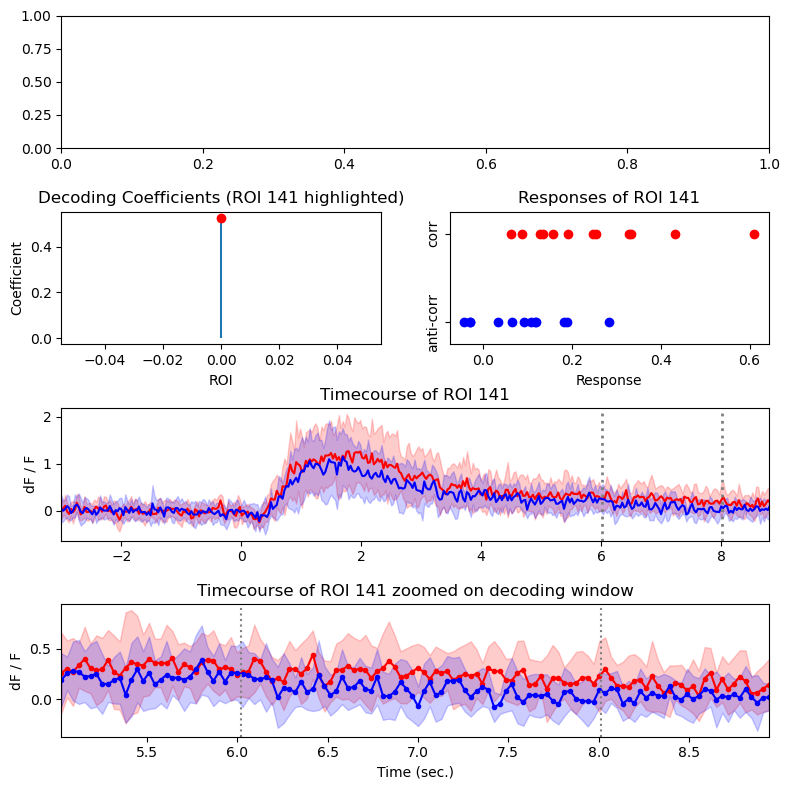

In [396]:
dt = (t[1]-t[0])/2
which_ranked_coef = -1
icoef = coefs_order[which_ranked_coef]
roi = ind_glom[icoef]
gs = GridSpec(4,2)
figure(figsize=(8,8))
subplot(gs[0,:2])

# We're going to plot everything by the _end_ time of the window
if False:
    tt = xx - odour_onset + wsz 
    fill_between(tt, yy - ss, yy + ss, color=list(mcolors.to_rgb(wsz_cols[wsz]))+[0.2])
    plot(tt,yy, ".-", color=wsz_cols[wsz], label = wsz_labs[wsz])
    indt = argmin(abs(xx - start_time))
    plot(tt[indt], yy[indt],"ro", markersize=10)
    ylim(0.3,1); xlabel("Time (sec.",labelpad=-1); ylabel("Accuracy"); vline(0, ":", color="gray");
    title(f"Odour {pair} at {freq} Hz decoded from a {wsz_labs[wsz]} window ending at t = {start_time - odour_onset + wsz:1.3f} sec.")
    xlim(tt[0]- wsz, tt[-1])
    
subplot(gs[1,0]);
stem(best_coefs, basefmt="C0", markerfmt = ".", use_line_collection = True); xlabel("ROI"); ylabel("Coefficient"); plot(icoef, best_coefs[icoef], "o", color="red")
title(f"Decoding Coefficients (ROI {roi} highlighted)")

#Z = copy(X) #(X - mean(X,axis=0))/std(X,axis=0)
subplot(gs[1,1]); plot(X[y>0, icoef], [1]*sum(y>0), "ro"); plot(X[y<0, icoef], [-1]*sum(y<0), "bo");
ylim([-1.5,1.5]); gca().set_yticks([-1,1]); gca().set_yticklabels(["anti-corr","corr"],rotation=90, verticalalignment="center");
xlabel("Response"); title(f"Responses of ROI {roi}")

subplot(gs[2,:]); plot_timecourses(X_sub[:, icoef, :],y, t - odour_onset)
wnd_start = t[ind_t[0]] - odour_onset - dt/2; wnd_end = t[ind_t[-1]] - odour_onset + dt/2;#xx[indt] - odour_onset; wnd_end   = wnd_start + wsz
vline(wnd_start, ":", color="gray",linewidth=2); vline(wnd_end, ":", color="gray", linewidth=2)
#xlim(t[0]-odour_onset, t[-1]-odour_onset)
xlim(tt[0]- wsz, tt[-1])
title(f"Timecourse of ROI {roi}"); ylabel("dF / F");

subplot(gs[3,:])
xl = [wnd_start - min(10*wsz, 1), wnd_end + min(10*wsz,1)]
indt_xl = where((t - odour_onset > xl[0]) & (t - odour_onset < xl[1]))[0]
t_xl = t[indt_xl] - odour_onset
plot_timecourses(X_sub[:, icoef, indt_xl],y, t_xl, style=".-")
xlim(t_xl[0], t_xl[-1]); vline(wnd_start, ":", color="gray"); vline(wnd_end, ":", color="gray");
title(f"Timecourse of ROI {roi} zoomed on decoding window"); xlabel("Time (sec.)"); ylabel("dF / F");
tight_layout(h_pad=0, w_pad=0.2)
fig_name = f"{pair}_{freq}Hz_wsz{wsz:1.3f}_{which_start_time:1.1f}_ROI{roi}.pdf"
print(fig_name)
#savefig(fig_name, bbox_inches = "tight")

In [352]:
X1 = copy(X_sub[:,19,:])

In [358]:
mu = mean(X1[:,:93].flatten())
sd = std(X1[:,:93].flatten())
sd_th = sd/sqrt(62)
mu, sd, sd_th

(-0.00012114798524307342, 0.15768373256287765, 0.020025854061349536)

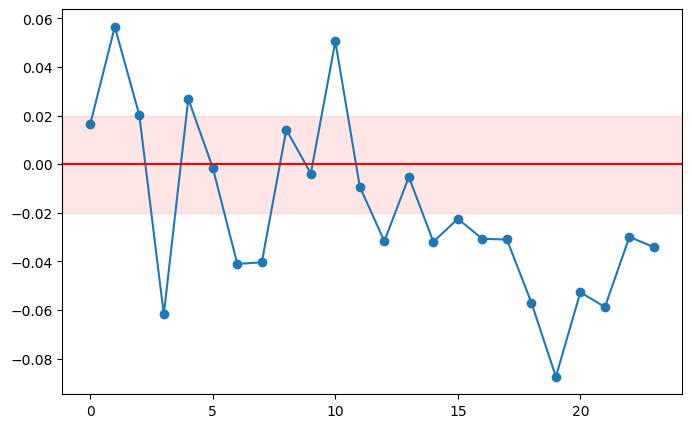

In [373]:
Xr = mean(X1[:, ind_t],axis=1)
plot(Xr,"o-"); xl = xlim()
fill_between(xl, [mu-sd_th]*2, [mu+sd_th]*2, color=[1,0,0,0.1])
plot(xl, [mu]*2, "r-"); xlim(xl);

In [374]:
0.75 * 24

18.0

# Filtering for responsive cells

In [19]:
ind_t = np.where((t>=3) & (t<5))[0]

In [191]:
_,_,_, X_all, ind_glom, ind_t = inputs.generate_input_for_config(conf._replace(start_time=5, freq=20, window_size=0.025), response_threshold = 1, min_resp_trials = 0.5, return_full = True)

DEBUG:inputs:generate_input_for_config


DEBUG:inputs:Generating input for Config(seed=0, n_sub=145, shuf=0, freq=20, pairs='AB', whiskers='yes', window_size=0.025, start_time=5)


DEBUG:inputs:Using pairs=['AB'].


DEBUG:inputs:Picked time indices 155 (5.017 sec.) to 155 (5.017 sec.) to span [config.start_time=5, end_time=5.025).


DEBUG:inputs:Filtering glomeruli by responsivity using response_threshold=1 and min_resp_trials=0.5.


DEBUG:inputs:filter_by_responsivity


DEBUG:inputs:Z-score range: -4.517 - 15.152.


DEBUG:inputs:Found 145 glomeruli with at least one responsive trial.


DEBUG:inputs:Received min_resp_trials=0.5


DEBUG:inputs:Interpreted as min_resp_trials=12 trials.


DEBUG:inputs:Flagging the 66 glomeruli with at least 12 responsive trials.


DEBUG:inputs:Found 66 responsive glomeruli: [0, 1, 2, 3, 4, 5, 8, 9, 11, 12, 14, 15, 16, 18, 19, 20, 24, 26, 28, 31, 32, 33, 40, 41, 42, 43, 57, 62, 63, 66, 67, 69, 70, 71, 73, 81, 84, 88, 91, 92, 93, 95, 97, 98, 104, 105, 111, 114, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 134, 137, 139, 141, 144]


DEBUG:inputs:Picked 66/n_resp_glom=66 responsive glomeruli: ind_glom=[0, 1, 2, 3, 4, 5, 8, 9, 11, 12, 14, 15, 16, 18, 19, 20, 24, 26, 28, 31, 32, 33, 40, 41, 42, 43, 57, 62, 63, 66, 67, 69, 70, 71, 73, 81, 84, 88, 91, 92, 93, 95, 97, 98, 104, 105, 111, 114, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 134, 137, 139, 141, 144]


DEBUG:inputs:Shape of predictors: X.shape=(24, 66)


DEBUG:inputs:(stim='20Hzanti-corr01', pair='AB') -> [-1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='20Hzanti-corr02', pair='AB') -> [-1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='20Hzcorr01', pair='AB') -> [1, 1, 1, 1, 1, 1]


DEBUG:inputs:(stim='20Hzcorr02', pair='AB') -> [1, 1, 1, 1, 1, 1]


DEBUG:inputs:Labels: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [298]:
conf

Config(seed=0, n_sub=145, shuf=0, freq=2, pairs='AB', whiskers='yes', window_size=2, start_time=9)

In [313]:
reload(inputs)
inputs.logger.setLevel(logging.DEBUG)
start = 9.8
_,_,_, X_all, ind_glom, ind_t = inputs.generate_input_for_config(conf._replace(start_time=start, window_size=2), response_threshold = 0, min_resp_trials = 0., return_full = True)
#X,y,t, X_sub, ind_glom, ind_t = inputs.generate_input_for_config(conf._replace(start_time=start), response_threshold = 1, min_resp_trials = 0.75, return_full = True)

DEBUG:inputs:generate_input_for_config


DEBUG:inputs:Generating input for Config(seed=0, n_sub=145, shuf=0, freq=2, pairs='AB', whiskers='yes', window_size=2, start_time=9.8)


DEBUG:inputs:Using pairs=['AB'].


DEBUG:inputs:Using 62 bins to approximate a desired window size of 2.000 with dt=0.032.


DEBUG:inputs:Picked time indices 303 (9.806 sec.) to 364 (11.781 sec.) to approximately span a config.window_size=2.000 second window starting at config.start_time=9.800 seconds.


DEBUG:inputs:Filtering glomeruli by responsivity using response_threshold=0 and min_resp_trials=0.0.


DEBUG:inputs:filter_by_responsivity


DEBUG:inputs:Z-score range: -24.509 - 59.107.


DEBUG:inputs:Found 145 glomeruli with at least one responsive trial.


DEBUG:inputs:Received min_resp_trials=0.0


DEBUG:inputs:Interpreted as min_resp_trials=0 trials.


DEBUG:inputs:Flagging the 145 glomeruli with at least 0 responsive trials.


DEBUG:inputs:Found 145 responsive glomeruli: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]


DEBUG:inputs:Picked 145/n_resp_glom=145 responsive glomeruli: ind_glom=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]


DEBUG:inputs:Shape of predictors: X.shape=(24, 145)


DEBUG:inputs:(stim='2Hzanti-corr01', pair='AB') -> [-1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='2Hzanti-corr02', pair='AB') -> [-1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='2Hzcorr01', pair='AB') -> [1, 1, 1, 1, 1, 1]


DEBUG:inputs:(stim='2Hzcorr02', pair='AB') -> [1, 1, 1, 1, 1, 1]


DEBUG:inputs:Labels: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [21]:
best_coefs, (X,y,t,X_sub,ind_glom,ind_t) = get_best_coefs(conf._replace(start_time=8.5,window_size=0.025), "lasso_lars_no_intercept", compute_accuracy = True, full = True,
                                                          response_threshold = 1, min_resp_trials = 0.75)

DEBUG:inputs:generate_input_for_config


DEBUG:inputs:Generating input for Config(seed=0, n_sub=145, shuf=0, freq=2, pairs='AB', whiskers='yes', window_size=0.025, start_time=8.5)


DEBUG:inputs:Using pairs=['AB'].


DEBUG:inputs:Picked time indices 263 (8.512 sec.) to 263 (8.512 sec.) to span [config.start_time=8.5, end_time=8.525).


DEBUG:inputs:Filtering glomeruli by responsivity using response_threshold=1 and min_resp_trials=0.75.


DEBUG:inputs:filter_by_responsivity


DEBUG:inputs:Z-score range: -5.063 - 8.758.


DEBUG:inputs:Found 145 glomeruli with at least one responsive trial.


DEBUG:inputs:Received min_resp_trials=0.75


DEBUG:inputs:Interpreted as min_resp_trials=18 trials.


DEBUG:inputs:Flagging the 1 glomeruli with at least 18 responsive trials.


DEBUG:inputs:Found 1 responsive glomeruli: [141]


DEBUG:inputs:Picked 1/n_resp_glom=1 responsive glomeruli: ind_glom=[141]


DEBUG:inputs:Shape of predictors: X.shape=(24, 1)


DEBUG:inputs:(stim='2Hzanti-corr01', pair='AB') -> [-1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='2Hzanti-corr02', pair='AB') -> [-1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='2Hzcorr01', pair='AB') -> [1, 1, 1, 1, 1, 1]


DEBUG:inputs:(stim='2Hzcorr02', pair='AB') -> [1, 1, 1, 1, 1, 1]


DEBUG:inputs:Labels: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


DEBUG:inputs:generate_input_for_config


DEBUG:inputs:Generating input for Config(seed=0, n_sub=145, shuf=0, freq=2, pairs='AB', whiskers='yes', window_size=0.025, start_time=8.5)


DEBUG:inputs:Using pairs=['AB'].


DEBUG:inputs:Picked time indices 263 (8.512 sec.) to 263 (8.512 sec.) to span [config.start_time=8.5, end_time=8.525).


DEBUG:inputs:Filtering glomeruli by responsivity using response_threshold=1 and min_resp_trials=0.75.


DEBUG:inputs:filter_by_responsivity


DEBUG:inputs:Z-score range: -5.063 - 8.758.


DEBUG:inputs:Found 145 glomeruli with at least one responsive trial.


DEBUG:inputs:Received min_resp_trials=0.75


DEBUG:inputs:Interpreted as min_resp_trials=18 trials.


DEBUG:inputs:Flagging the 1 glomeruli with at least 18 responsive trials.


DEBUG:inputs:Found 1 responsive glomeruli: [141]


DEBUG:inputs:Picked 1/n_resp_glom=1 responsive glomeruli: ind_glom=[141]


DEBUG:inputs:Shape of predictors: X.shape=(24, 1)


DEBUG:inputs:(stim='2Hzanti-corr01', pair='AB') -> [-1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='2Hzanti-corr02', pair='AB') -> [-1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='2Hzcorr01', pair='AB') -> [1, 1, 1, 1, 1, 1]


DEBUG:inputs:(stim='2Hzcorr02', pair='AB') -> [1, 1, 1, 1, 1, 1]


DEBUG:inputs:Labels: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


train_acc=0.776, test_acc=0.800


## Loading the filtered data

In [172]:
def load_filtered_results(pairs, window_size, whiskers, clf = "lasso_lars_no_intercept", dt = -1, response_threshold = 1.0, min_resp_trials = 0.5, name = "filt_nsub145_100x", max_load = 100, full = False):
    name = "filt_nsub145_100x"
    name = f"{name}_{pairs}_{int(window_size*1000)}ms_W{whiskers}DT_rt{response_threshold:1.3f}_mrt{min_resp_trials}".replace("DT", f"_dt{dt}" if dt > 0 else "")
        
    logger.info(f"{name=}")
    config = {"output_prefix":"", "raw":False, "mock":"null", "classifier":clf}
    output_dir = run.get_output_folder_name(config, head = f"data/sweeps/{name}")
    logger.info(output_dir)
    records = []
    for f in os.scandir(output_dir):
        if f.is_file() and f.name.endswith(".csv"):
            records.append(pd.read_csv(f))
        if len(records) >= max_load:
            break
    logger.info(f"Read {len(records)} csv files, with {max_load=}")
    df = pd.concat(records)
    logger.info(f"Created dataframe with {len(df)} rows.")
    col_names = list(df.columns)
    logger.info(f"Columns: {col_names}")
    df.head()
    logger.info(f"Accuracy at 3 sec. using all ROIs at 2 Hz: {mean(df[(df.start_time == 3) & (df.shuf == 0) & (df.freq==2)]['test_score']):1.3f}")
    # Set a flag for whether this was a shuffle run or not.
    df.loc[df.shuf>0, "shuf"]=1
    df2 = df.groupby(['shuf','freq','start_time'], as_index=False).agg({'train_score':['mean', 'std'], 'test_score':['mean', 'std'], 'n_sub':['mean','std','count']})
    df2.columns = [c  + ("_" if len(d) else "") + d for (c,d) in df2.columns.to_flat_index()]
    return (df2, df) if full else df2


In [198]:
conf

Config(seed=0, n_sub=145, shuf=0, freq=2, pairs='AB', whiskers='yes', window_size=2, start_time=9)

In [200]:
dff, df1 = load_filtered_results("AB", 0.025, "yes", full=True, dt = 0.2)

In [201]:
df1[(df1.shuf==0) & (df1.seed==0) & (df1.window_size == 0.025) & (df1.start_time == 5)]

,seed,n_sub,shuf,freq,pairs,whiskers,window_size,start_time,response_threshold,min_resp_trials,train_score,test_score
25,0,71,0,2,AB,yes,0.025,5.0,1.0,0.5,1.000000,0.766667
75,0,66,0,20,AB,yes,0.025,5.0,1.0,0.5,0.609524,0.266667


In [314]:
xysnf = {}
dt = 0.2
name = "filt_nsub145_100x"
clf = "lasso_lars_no_intercept"
df_filt_wsz = {(pair, wsz, rt, mrt):load_filtered_results(pair, wsz, "yes", clf, dt = 0.2, response_threshold = rt, min_resp_trials = mrt)
               for pair in ["AB", "CD", "EF"] for wsz in window_sizes for (rt,mrt) in [(1.0, 0.5), (1.0, 0.75), (2.0,0.5)]}
for (pair, wsz,rt,mrt), df in df_filt_wsz.items():
    for (sh, freq) in [(0,2),(0,20),(1,2),(1,20)]:
        xysnf[pair,wsz,sh,freq,rt,mrt] = df[(df.shuf==sh) & (df.freq==freq)][["start_time", "test_score_mean", "test_score_std", "n_sub_mean"]].sort_values(by="start_time").to_numpy().T

(-5.0, 150.0)

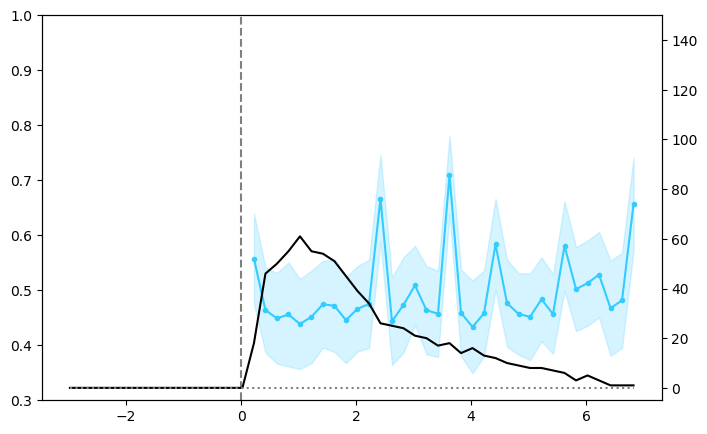

In [251]:
freq = 20
shuf = 0
pair = "EF"
wsz = 0.025
rt = 2.
mrt = 0.5
x,y,s,n = xysnf[pair,wsz,shuf,freq,rt, mrt];
u = x - 3 + wsz
fill_between(u, y-s,y+s,color=set_alpha(wsz_cols[wsz],0.2))
plot(u, y, ".-", color=wsz_cols[wsz])
ylim(0.3,1)
vline(0, "--", color="gray")
ax1 = gca().twinx()
ax1.plot(u,n,"k")
ax1.plot(u,0*x,":",color="gray")
ax1.set_ylim(-5,150)

#### How does the number of active glomeruli change with the thresholding?

In [315]:
th_styles = {(1,0.5):"o", (1,0.75):"v", (2,0.5):"x"}

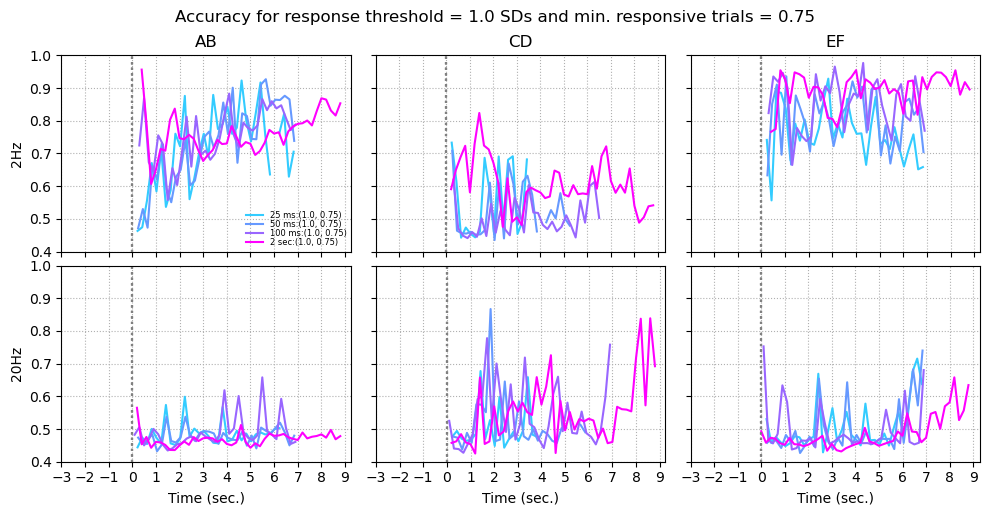

In [321]:
show_shuf = False
sh_freq = [(0,2),(0,20)] + ([(1,2),(1,20)] if show_shuf else [])
min_xlabs = True
min_ylabs = True
figure(figsize=(10, 5 + (show_shuf)*5))
gs = GridSpec(4 if show_shuf else 2, 3)
ax = {}
which_th = (1.0,0.75)
what_to_plot = "acc"
ylims = {"acc":(0.4,1), "counts":(-5,150)}
for ip, pair in enumerate(["AB", "CD","EF"]):
    for wsz in [0.025,0.050,0.1,2]:#window_sizes:
        for isf, (sh, freq) in enumerate(sh_freq):
            for (rt,mrt), sty in th_styles.items():
                if (rt,mrt) != which_th:
                    continue
                xx,yy,ss,nn = xysnf[pair, wsz,sh,freq,rt,mrt]            
                ax[isf,ip] = subplot(gs[isf,ip]) if (isf,ip) not in ax else ax[isf,ip]
                #(wsz > 2) and ax[isf,ip].fill_between(xx - 3 + wsz, yy - ss,  yy + ss, color=list(mcolors.to_rgb(wsz_cols[wsz]))+[0.2])            
                ax[isf,ip].plot(xx - 3 + wsz, nn if what_to_plot == "counts" else yy, "-", markersize=3, color=wsz_cols[wsz], label=wsz_labs[wsz]+f":({rt:1.1f}, {mrt:1.2f})", linewidth=1.5)
                ax[isf,ip].plot([0,0],[0.4,1],":",color="gray");
                ax[isf,ip].set_ylim(ylims[what_to_plot])
            
for ip, pair in enumerate(["AB", "CD", "EF"]):
    for isf, (sh, freq) in enumerate(sh_freq):
        ax[isf,ip].set_ylim(ylims[what_to_plot])
        ax[isf,ip].set_xticks(arange(0,13,1)-3)
#        ax[isf,ip].set_yticks(arange(0.4,1.01,0.1))
        (isf != 3) and (isf != len(sh_freq)-1) and min_xlabs and ax[isf,ip].set_xticklabels([])
        (ip  != 0) and min_ylabs and ax[isf,ip].set_yticklabels([])    
        (ip  == 0) and ax[isf,ip].set_ylabel(f"{freq}Hz" + (" (sh) " if sh else ""))
        (isf == 0) and ax[isf,ip].set_title(pair)
        (isf == len(sh_freq)-1) and ax[isf,ip].set_xlabel("Time (sec.)")
        ax[isf, ip].grid(True, linestyle=":")
#        ax[isf,ip].set_xlim(xx[0],xx[0,20][-1])
ax[0,0].legend(frameon=False, fontsize=6, labelspacing=0, borderpad=0)
tight_layout(h_pad=0)
suptitle(f"{'# responsive cells' if what_to_plot=='counts' else 'Accuracy'} for response threshold = {which_th[0]:1.1f} SDs and min. responsive trials = {which_th[1]:1.2f}", y = 1.02)
file_name = f"{what_to_plot}_{which_th[0]:1.1f}_{which_th[1]:1.2f}.pdf"
savefig(file_name, bbox_inches="tight")

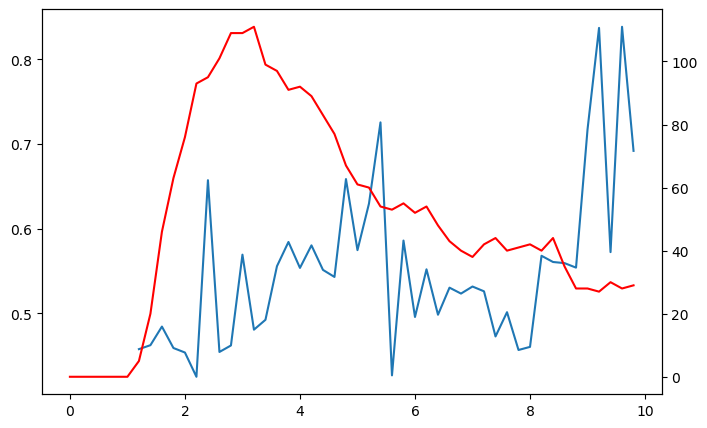

In [328]:
x1,y1,s1,n1 = xysnf["CD",2,0,20,1.,0.75]
plot(x1,y1)
ax = gca().twinx()
ax.plot(x1,n1,"r")

In [330]:
x1[argsort(-y1)[:10]]

array([9.6, 9.2, 5.4, 9. , 9.8, 4.8, 2.4, 5.2, 5.8, 3.8])

# Coefficients as window size changes

In [28]:
inputs.logger.setLevel(logging.INFO)
freq = 20
pair = "CD"
whis = "yes"
start_time = -2 + 3
configs = {wsz:inputs.Config(seed=0,shuf=0, window_size = wsz, n_sub = 145, freq=freq, pairs=pair, whiskers=whis, start_time = start_time) for wsz in window_sizes}
best_coefs = {k:get_best_coefs(config, clf) for k,config in configs.items()}
XY = {k:inputs.generate_input_for_config(config, return_full = True) for k,config in configs.items()}

In [706]:
coefs = best_coefs[wsz]
order = argsort(coefs)
which_coef = order[0]

Wrote coefs_EF_2Hz_3.5sec_ROI134.pdf.


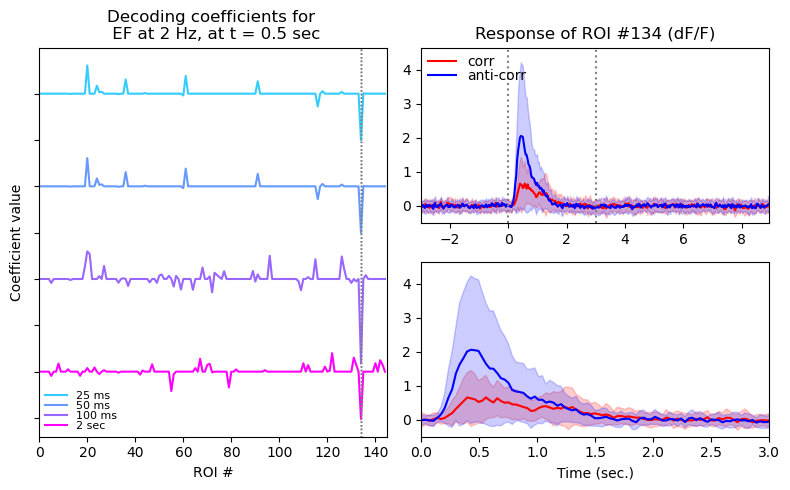

In [707]:
figure(figsize=(8,5))
gs = GridSpec(2,2)
subplot(gs[:,0])
[plot(best_coefs[wsz]-i, color=wsz_cols[wsz], label = wsz_labs[wsz]) for i, wsz in enumerate(window_sizes)]
yl = ylim()
[plot([which_coef, which_coef], yl, ":",color="gray", linewidth=1) for i, wsz in enumerate(window_sizes)]
ylim(yl)
gca().set_yticklabels([])
xlim(0,len(coefs))
ylabel("Coefficient value")
title(f"Decoding coefficients for \n {pair} at {freq} Hz, at t = {start_time-3} sec")
xlabel("ROI #")
legend(frameon=False, fontsize=8, labelspacing=0, borderpad=0)
X,y,t,X_sub,ind_glom = XY[wsz]
mp = mean(X_sub[y>0], axis=0)[which_coef]; sp = std(X_sub[y>0],  axis=0)[which_coef]
mn = mean(X_sub[y<0], axis=0)[which_coef]; sn = std(X_sub[y<0],  axis=0)[which_coef]
intervals = [(t[0],t[-1]), (start_time-0.5, start_time+2.5)]
for i, xl in enumerate(intervals):
    subplot(gs[i,1])
    ti = where((t>=xl[0]) & (t<=xl[1]))[0]
    fill_between(t-3, mp-sp, mp + sp, color=[1,0,0,0.2])
    fill_between(t-3, mn-sn, mn + sn, color=[0,0,1,0.2])
    plot(t-3, mp, color="r", label = "corr")
    plot(t-3, mn, color="b", label = "anti-corr")
    yl = [-0.5, 1.1*np.max(np.maximum((mp+sp)[ti], (mn+sn)[ti]))]
    (i == 0) and [plot([t-3,t-3],yl, ":", color="gray") for t in intervals[1]]
    xlim(array(xl)-3)
    ylim(yl)
    (i==0) and title(f"Response of ROI #{which_coef} (dF/F)")
    (i==0) and legend(frameon=False, labelspacing=0, borderpad=0, fontsize=10, loc = "upper left")
    (i==1) and xlabel("Time (sec.)")
tight_layout()
file_name = f"wsz_coefs_{pair}_{freq}Hz_{start_time:1.1f}sec_ROI{which_coef}.pdf"
savefig(file_name, bbox_inches="tight")
print(f"Wrote {file_name}.")

# Effect of Nonlinear Decoding

In [743]:
logger.setLevel(logging.WARNING)
whis = "both"
window_size = 2
start_time = 3
clfs = ["lasso_lars_no_intercept", "svc_poly", "svc_rbf", "svc_sigmoid"] 
df_clf = {(pair, clf):load_results(pair, whis, window_size , clf) for pair in ["AB", "CD", "EF"] for clf in clfs}

In [746]:
xys = {}
n_glom = 145
for (pair, clf), df in df_clf.items():
    for (sh, freq) in [(0,2),(0,20),(1,2),(1,20)]:
        xys[(pair,clf,sh,freq)] = df[(df.start_time == start_time) & (df.shuf==sh) & (df.freq==freq)][["n_sub", "test_score_mean", "test_score_std"]].sort_values(by="n_sub").to_numpy().T


In [ ]:
cm_clf   = cm.viridis
clf_cols = {"svc_poly":cm_clf(0.2), "svc_rbf":cm_clf(0.4), "svc_sigmoid":cm_clf(0.6), "lasso_lars_no_intercept":cm_clf(1.)}
clf_labs = {"svc_poly":"poly", 0.05:"50 ms", 0.1:"100 ms", 2:"2 sec"}
show_shuf = False
sh_freq = [(0,2),(0,20)] + ([(1,2),(1,20)] if show_shuf else [])
min_xlabs = True
min_ylabs = True
figure(figsize=(8,4 + (show_shuf)*4))
gs = GridSpec(4 if show_shuf else 2, 3)
ax = {}
for ip, pair in enumerate(["AB", "CD","EF"]):
    for wsz in window_sizes:
        for isf, (sh, freq) in enumerate(sh_freq):
            xx,yy,ss = xys[pair, wsz,sh,freq]            
            ax[isf,ip] = subplot(gs[isf,ip]) if (isf,ip) not in ax else ax[isf,ip]
            #ax[isf,ip].fill_between(xx, yy - ss,  yy + ss, color=list(mcolors.to_rgb(wsz_cols[wsz]))+[0.2])            
            ax[isf,ip].plot(xx-3, yy, color=wsz_cols[wsz], label=wsz_labs[wsz], linewidth=1.5)
            ax[isf,ip].plot([0,0],[0.4,1],":",color="gray");
            ax[isf,ip].set_ylim([0.4,1])
            
for ip, pair in enumerate(["AB", "CD", "EF"]):
    for isf, (sh, freq) in enumerate(sh_freq):
        ax[isf,ip].set_ylim(0.4,1)
        ax[isf,ip].set_xticks(arange(0,10,1)-3)
        ax[isf,ip].set_yticks(arange(0.4,1.01,0.1))
        (isf != 3) and (isf != len(sh_freq)-1) and min_xlabs and ax[isf,ip].set_xticklabels([])
        (ip  != 0) and min_ylabs and ax[isf,ip].set_yticklabels([])    
        (ip  == 0) and ax[isf,ip].set_ylabel(f"{freq}Hz" + (" (sh) " if sh else ""))
        (isf == 0) and ax[isf,ip].set_title(pair)
        (isf == len(sh_freq)-1) and ax[isf,ip].set_xlabel("Time (sec.)")
        #ax[isf,ip].set_xlim(xx[0,20][0],xx[0,20][-1])
ax[0,0].legend(loc="upper right", frameon=False, fontsize=10, labelspacing=0, borderpad=0)
tight_layout(h_pad=0)
#savefig("effect_of_nonlinear_decoding.pdf", bbox_inches="tight")

# Miscellaneous

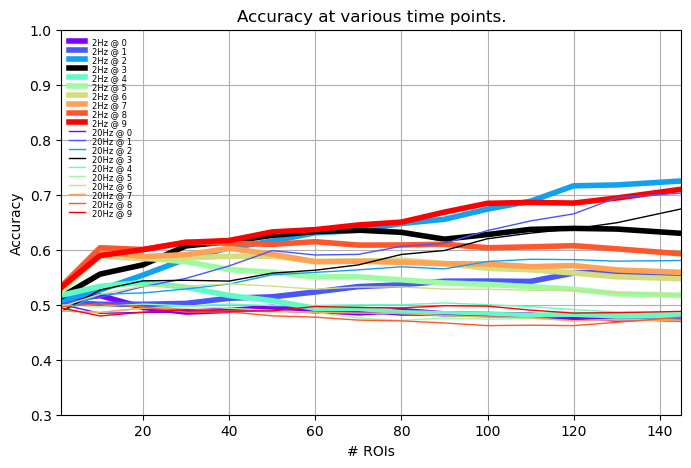

In [77]:
df_sub  = {(freq,t):df2[(df2.start_time == t) & (df2.freq==freq) & (df2.shuf==0)].sort_values(by=["n_sub"]) for t in range(0,10,1) for freq in [2,20]}
figure(figsize=(8,5))
for (freq,t) in sorted(df_sub):
    col = "k" if t==3 else cm.rainbow(t/9.)# if freq==2 else cm.rainbow(t/10.)
    x = df_sub[freq,t]["n_sub"].values
    ym= df_sub[freq,t]["test_score_mean"]
    plot(x,ym,color=col, label=f"{freq}Hz @ {t}", linewidth = 4 if freq==2 else 1)
ylim(0.3,1)
legend(fontsize=6,frameon=False,loc="upper left", labelspacing=0)
xlim(x[0],x[-1])
xlabel("# ROIs")
ylabel("Accuracy")
title(f"Accuracy at various time points.", fontsize=12)
grid(True)

In [103]:
freq = 20
config = inputs.Config(seed=0,
                       shuf=0,
                       window_size = window_size,
                       n_sub = 145,                       
                       freq=freq,
                       pairs="AB", 
                       whiskers=whiskers,
                       start_time = start_time)
print(config)
X, y, t, X_sub, ind_glom = inputs.generate_input_for_config(config, return_full = True)
search, _   = run.get_pipeline(classifier=clf, return_pipe=True)
search.fit(X,y)

Config(seed=0, n_sub=145, shuf=0, freq=20, pairs='AB', whiskers='both', window_size=2, start_time=3)
